## 准备

- 数据集下载地址请点<a href = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip">此处</a>。(数据集大小约750多MB)
<br>解压缩数据集，会发现它创建了一个名为PetImages的目录。在其中，有猫和狗目录，然后填充猫和狗的图像。

- 需要matplotlib库
<br>可通过以下方式安装（如果已有opencv请跳过第二行）
```shell
pip install matpltlib
pip install opencv-python
```

要先对数据集中的图片进行处理，可能需要进行的任务有图像尺寸统一、颜色处理等：

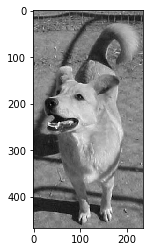

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "../datasets/PetImages" # 数据集的路径，请根据需要修改

CATEGORIES = ["Dog", "Cat"]

for category in CATEGORIES: 
    path = os.path.join(DATADIR,category)  # 创建路径
    for img in os.listdir(path):  # 迭代遍历每个图片
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # 转化成array
        plt.imshow(img_array, cmap='gray')  # 转换成图像展示
        plt.show()  # display!

        break  # 我们作为演示只展示一张，所以直接break了
    break  #同上

看下array中存储的图像数据：

In [2]:
print(img_array)

[[144 137 136 ..., 125 134 134]
 [140 132 133 ..., 122 129 129]
 [139 131 133 ..., 126 132 132]
 ..., 
 [128 133 139 ..., 137 137 137]
 [138 139 139 ..., 137 137 137]
 [138 139 139 ..., 137 137 137]]


看下array的形状：

In [3]:
print(img_array.shape)

(467, 235)


我们可以看到这是一张很大的图片，并且拥有RGB3个通道，这并不是我们想要的，所以接下来我们将要进行的操作会使图像变小，并且只剩下灰度：

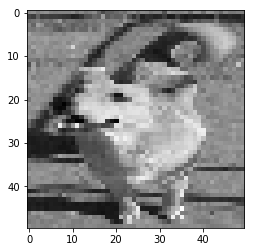

In [4]:
IMG_SIZE = 50

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

SIZE设置成50有一些模糊，尝试下100：

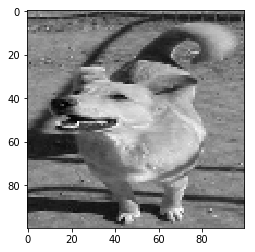

In [5]:
IMG_SIZE = 100
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

接下来，我们将要创建所有这些培训数据，但是，首先，我们应该留出一些图像进行最终测试。我将手动创建一个名为Testing的目录，然后在其中创建2个目录，一个用于Dog，一个用于Cat。从这里开始，我将把Dog和Cat的前15张图像移到训练版本中。确保移动它们，而不是复制。我们将使用它进行最终测试。

In [6]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category)  # 得到分类，其中 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # 大小转换
                training_data.append([new_array, class_num])  # 加入训练数据中
            except Exception as e:  # 为了保证输出是整洁的
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 12501/12501 [00:35<00:00, 350.78it/s]

24946


我们有大约25,000张图片。
<br>我们要做的一件事是确保我们的数据是平衡的。在这个数据集的情况下，我可以看到数据集开始时是平衡的。平衡，我的意思是每个班级都有相同数量的例子（相同数量的狗和猫）。如果不平衡，您要么将类权重传递给模型，以便它可以适当地测量误差，或者通过将较大的集修剪为与较小集相同的大小来平衡样本。
<br>现在数据集中要么全是dog要么全是cat，因此接下来要引入随机：

In [7]:
import random

random.shuffle(training_data)

我们的training_data是一个列表，这意味着它是可变的，所以它现在很好地改组了。我们可以通过迭代几个初始样本并打印出类来确认这一点：

In [8]:
for sample in training_data[:10]:
    print(sample[1])

0
1
0
1
1
0
1
0
1
0


现在可以看到已经是0、1交替了，我们可以开始我们的模型了：

In [9]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

[[[[ 95]
   [ 79]
   [107]
   ..., 
   [ 31]
   [ 59]
   [ 75]]

  [[ 56]
   [116]
   [104]
   ..., 
   [ 84]
   [ 33]
   [ 43]]

  [[ 23]
   [ 54]
   [ 45]
   ..., 
   [ 97]
   [ 46]
   [ 90]]

  ..., 
  [[179]
   [101]
   [120]
   ..., 
   [166]
   [150]
   [146]]

  [[128]
   [103]
   [127]
   ..., 
   [153]
   [112]
   [142]]

  [[145]
   [117]
   [158]
   ..., 
   [125]
   [ 79]
   [145]]]]


让我们保存这些数据，这样我们就不需要每次想要使用神经网络模型时继续计算它：

In [12]:
import pickle

pickle_out = open("../datasets/X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("../datasets/y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()
# We can always load it in to our current script, or a totally new one by doing:

pickle_in = open("../datasets/X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("../datasets/y.pickle","rb")
y = pickle.load(pickle_in)

现在我们已经拿出了数据集，我们已经准备好覆盖卷积神经网络，并用我们的数据进行分类。
<br>以上就是这次的关于数据集操作的全部任务。